In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:

from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
df_full = pdr.get_data_yahoo("LT.NS", start="2022-01-01",end="2024-03-29").reset_index()
df_full.to_csv('LT.csv',index=False)
df_full.head()


[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-03,1895.000000,1937.449951,1893.650024,1922.849976,1894.265625,1906676
1,2022-01-04,1922.849976,1943.000000,1914.550049,1937.550049,1908.747070,1643920
2,2022-01-05,1940.699951,1951.000000,1927.650024,1948.599976,1919.632812,1711667
3,2022-01-06,1944.500000,1953.000000,1919.599976,1924.500000,1895.891113,1372015
4,2022-01-07,1929.050049,1934.949951,1897.150024,1904.900024,1876.582520,1447123


Text(0.5, 1.0, 'Closing Price')

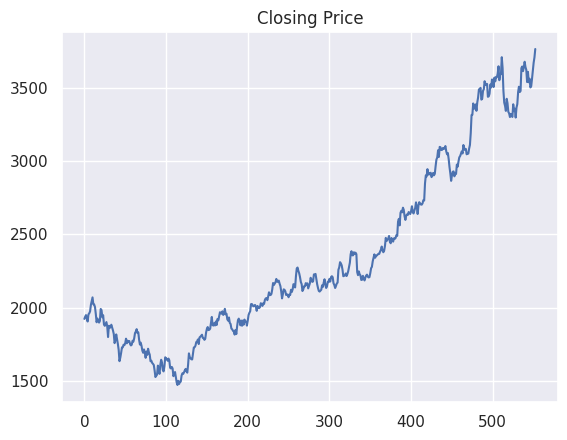

In [ ]:
df_full['Close'].plot()
plt.title('Closing Price')

In [ ]:
from collections import deque
import random

df= df_full.copy()
name = 'Q-learning agent'

class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost

    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)

            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))


            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )

            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)

                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]

                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest,
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 16
agent = Agent(state_size = window_size,
              window_size = window_size,
              trend = close,
              skip = skip,
              batch_size = batch_size)
agent.train(iterations = 400, checkpoint = 20, initial_money = initial_money)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
<ipython-input-6-91f25f853109>:28: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
<ipython-input-6-91f25f853109>:29: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(feed, self.action_size)


epoch: 20, total rewards: 3420.299316.3, cost: 0.246963, total money: 13420.299316
epoch: 40, total rewards: 3413.249390.3, cost: 0.057563, total money: 13413.249390
epoch: 60, total rewards: 4078.348999.3, cost: 0.134904, total money: 14078.348999
epoch: 80, total rewards: 3252.398071.3, cost: 0.010462, total money: 13252.398071
epoch: 100, total rewards: 3617.098999.3, cost: 0.127298, total money: 13617.098999
epoch: 120, total rewards: 3499.448608.3, cost: 0.020321, total money: 13499.448608
epoch: 140, total rewards: 3099.898071.3, cost: 5.000862, total money: 13099.898071
epoch: 160, total rewards: 3828.648926.3, cost: 0.021586, total money: 13828.648926
epoch: 180, total rewards: 2636.648560.3, cost: 0.019019, total money: 12636.648560
epoch: 200, total rewards: 3855.599121.3, cost: 0.039581, total money: 13855.599121
epoch: 220, total rewards: 2914.649048.3, cost: 0.005394, total money: 12914.649048
epoch: 240, total rewards: 3845.299316.3, cost: 2.228885, total money: 13845.299

In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 1922.849976, total balance 8077.150024
day 1: buy 1 unit at price 1937.550049, total balance 6139.599976
day 2, sell 1 unit at price 1948.599976, investment 1.339158 %, total balance 8088.199951,
day 3, sell 1 unit at price 1924.500000, investment -0.673534 %, total balance 10012.699951,
day 4: buy 1 unit at price 1904.900024, total balance 8107.799927
day 5, sell 1 unit at price 1953.099976, investment 2.530314 %, total balance 10060.899902,
day 9: buy 1 unit at price 2044.750000, total balance 8016.149902
day 12, sell 1 unit at price 2020.900024, investment -1.166401 %, total balance 10037.049927,
day 13: buy 1 unit at price 2003.500000, total balance 8033.549927
day 14: buy 1 unit at price 1956.050049, total balance 6077.499878
day 15: buy 1 unit at price 1899.900024, total balance 4177.599854
day 16, sell 1 unit at price 1925.300049, investment -3.903167 %, total balance 6102.899902,
day 17, sell 1 unit at price 1910.849976, investment -2.310783 %, total 

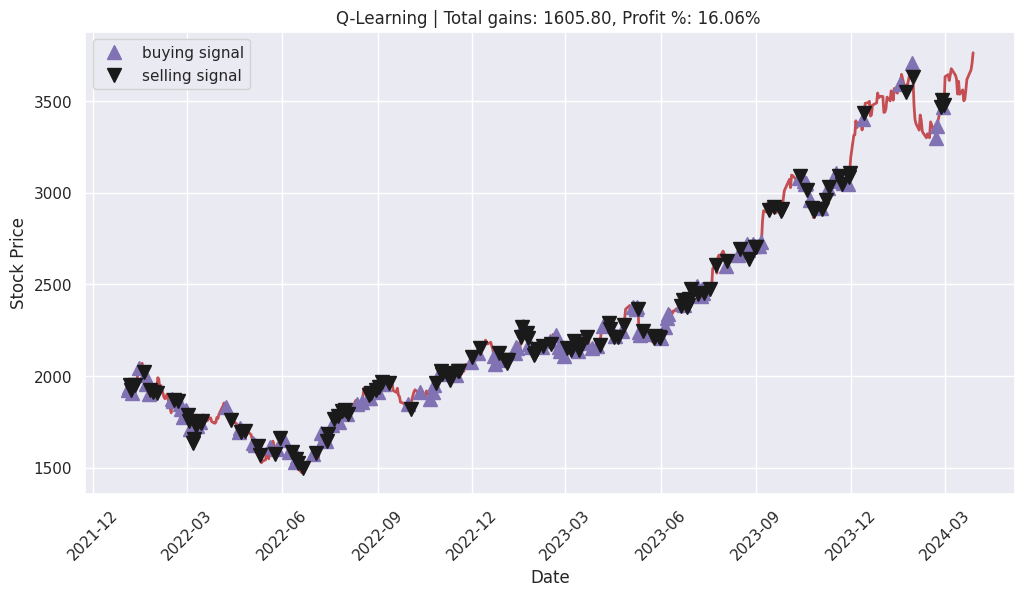

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd


# Extract date and close price
date = pd.to_datetime(df['Date'])
close = df['Close']

# Get the index of the first closing value
first_closing_index = close.first_valid_index()

# Extract the date and close price starting from the first closing value
date = date[first_closing_index:]
close = close[first_closing_index:]
plt.figure(figsize=(12, 6))
plt.plot(date, close, color='r', lw=2.)

# Plot markers for buying and selling signals
plt.plot(date[states_buy], close[states_buy], '^', markersize=10, color='m', label='buying signal')
plt.plot(date[states_sell], close[states_sell], 'v', markersize=10, color='k', label='selling signal')

plt.title('Q-Learning | Total gains: %.2f, Profit %%: %.2f%% '% (total_gains, invest))

# Set the locator for x-axis ticks to show dates every three months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [ ]:
# Calculate performance metrics
def calculate_metrics(states_buy, states_sell, close_prices, initial_money):
    total_gains = close_prices[-1] - close_prices[0]
    ROI = ((close_prices[-1] - close_prices[0]) / close_prices[0]) * 100

    # Calculate Sharpe Ratio (assuming risk-free rate is 0)
    returns = np.diff(close_prices) / close_prices[:-1]
    sharpe_ratio = np.sqrt(252) * np.mean(returns) / np.std(returns)

    # Calculate maximum drawdown
    max_drawdown = np.max(np.maximum.accumulate(close_prices) - close_prices) / np.max(np.maximum.accumulate(close_prices))

    # Calculate winning trades percentage
    winning_trades = len(states_sell) / (len(states_buy) + len(states_sell)) * 100

    # Calculate average return per trade
    avg_return_per_trade = total_gains / (len(states_buy) + len(states_sell))

    # Calculate average holding period
    holding_periods = [sell - buy for buy, sell in zip(states_buy, states_sell)]
    avg_holding_period = np.mean(holding_periods)

    # Other metrics such as risk of ruin, Calmar ratio, and Sortino ratio can be calculated as needed

    return total_gains, ROI, sharpe_ratio, max_drawdown, winning_trades, avg_return_per_trade, avg_holding_period

# Simulate trading and compute performance metrics
initial_money = 10000
close_prices = df_full['Close'].values
total_gains, ROI, sharpe_ratio, max_drawdown, winning_trades, avg_return_per_trade, avg_holding_period = calculate_metrics(
    states_buy, states_sell, close_prices, initial_money)

# Print performance metrics
print('Q-learning')
print("Performance Metrics:")
print("Total Gains: {:.2f}".format(total_gains))
print("Return on Investment (ROI): {:.2f}%".format(ROI))
print("Sharpe Ratio: {:.2f}".format(sharpe_ratio))
print("Maximum Drawdown: {:.2f}%".format(max_drawdown * 100))
print("Winning Trades Percentage: {:.2f}%".format(winning_trades))
print("Average Return per Trade: {:.2f}".format(avg_return_per_trade))
print("Average Holding Period: {:.2f}".format(avg_holding_period))


Q-learning
Performance Metrics:
Total Gains: 1841.05
Return on Investment (ROI): 95.75%
Sharpe Ratio: 1.46
Maximum Drawdown: 15.88%
Winning Trades Percentage: 50.00%
Average Return per Trade: 7.74
Average Holding Period: 4.85


In [ ]:
import numpy as np

def sharpe_ratio(returns, risk_free_rate=0):
    avg_return = np.mean(returns)
    std_dev = np.std(returns)
    sharpe = (avg_return - risk_free_rate) / std_dev if std_dev != 0 else np.nan
    return sharpe

# Example usage:
if __name__ == "__main__":
    # Example returns data (replace with your own data)
    returns_data = np.random.normal(0.001, 0.02, 100)  # Generating random returns data for demonstration
    risk_free_rate = 0.02  # Assumed annual risk-free rate
    # Calculate Sharpe Ratio
    sharpe = sharpe_ratio(returns_data, risk_free_rate)
    print("Sharpe Ratio:", sharpe)